<a href="https://colab.research.google.com/github/corelogic/gcoe_geospatial_imagery_analytics/blob/master/firebreak_image_classification/FastAI_Classifier_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 186 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 


In [2]:
from fastai.vision.all import *

# **Mount GCP Bucket**

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
#Mount gcp bucket

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0    99k      0 --:--:-- --:--:-- --:--:--  103k
OK
79 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 79 not upgraded.
Need to get 10.8 MB of archives.
After this operation, 23.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.36.0_amd64.deb ...
Unpacking gcsfuse (0.36.0) ...
Setting up gcsfuse (0.36.0) ...


In [5]:
#More mounting

!mkdir gcoeBucket
!gcsfuse --implicit-dirs geospatial-analytics gcoeBucket

2021/09/14 21:34:46.014728 Using mount point: /content/gcoeBucket
2021/09/14 21:34:46.023784 Opening GCS connection...
2021/09/14 21:34:46.309369 Mounting file system "geospatial-analytics"...
2021/09/14 21:34:46.344257 File system has been successfully mounted.


In [6]:
#Test the mount worked
!ls gcoeBucket/firebreak_image_classification/Colorado

jpg_footprints	jpg_images


# **Define Regex Function**

In [7]:
# Name variable for path to images

import pathlib

photoDir = 'gcoeBucket/firebreak_image_classification/Colorado/jpg_images/'
data_dir = pathlib.Path(photoDir)
print(data_dir)

gcoeBucket/firebreak_image_classification/Colorado/jpg_images


In [8]:
# Use the fastai function 'get_image_files' to retreive all the image files in one folder. it is recursive! so it get all the images in subfolders too.
files = get_image_files(data_dir)

# Get a count of all image files in data directory
len(files)

19452

In [9]:
# Show me some of the pathname examples to get the category from the file names of images

files[0], files[16000], files[9000].name, files[7000].name

(Path('gcoeBucket/firebreak_image_classification/Colorado/jpg_images/Agriculture1000209.jpg'),
 Path('gcoeBucket/firebreak_image_classification/Colorado/jpg_images/Wildland497236.jpg'),
 'Urban Non-Residential1661645.jpg',
 'Medium Density Residential1523892.jpg')

In [10]:
# The pattern is always the same. The category name is followed by the unique ID
# numbers and then the file extension.

files[0].name, files[10000].name

('Agriculture1000209.jpg', 'Urban1586495.jpg')

In [11]:
# Define a function for pulling category labels from image filenames.

import re

print(files[0].name)

def get_labels(file_path):
  return re.sub(r'\d+.jpg','', str(file_path))

get_labels(files[0].name)

Agriculture1000209.jpg


'Agriculture'

## **Load Data to Dataloaders**

In [39]:
# Define a dataloader for images using the from_folder loader and resizing images 
'''
# Below is from: https://gist.github.com/ksasi/6278dbf8f474c5535e870865c0058a48 and it does not work
bs = 64
np.random.seed(10)
dls = ImageDataBunch.from_folder(path_img, train = '.', valid_pct = 0.2, ds_tfms = get_transforms(), size = 256, bs = bs)
data.normalize(imagenet_stats)
'''

print('Path to JPG directory:\n\t{0}'.format(data_dir))

# Testing dataloaders
#dls = ImageDataLoaders.from_name_func(data_dir, files, get_labels, item_tfms=Resize(224)) #"basic bitch" Works
dls = ImageDataLoaders.from_name_func(data_dir, files, get_labels, valid_pct=0.2, seed=42, item_tfms=Resize(224), bs=64) #Works

# From Jawsem, but I am missing something. CUDA out of memory error pops up when I use show_batch(). Maybe the batch augmentation transform is too much?
#dls = ImageDataLoaders.from_name_func(data_dir, files, get_labels, valid_pct=.2, seed=42, batch_tfms=[*aug_transforms(size=224,min_scale=0.75),Normalize.from_stats(*imagenet_stats)],bs=64)

Path to JPG directory:
	gcoeBucket/firebreak_image_classification/Colorado/jpg_images


In [54]:
#List out the categories
print('There are {0} categories.'.format(dls.c))

There are 9 categories.


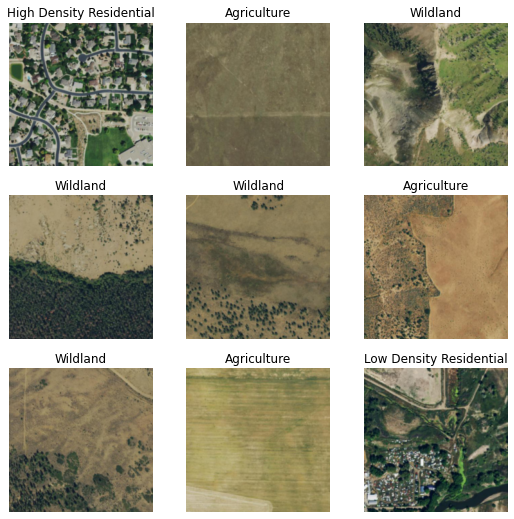

In [50]:
# Display some sample images from the data loader to check the labels and augmentations

dls.show_batch()

## **Training: resnet18**

In [55]:
# This learner is taken straight from Jawsem's code
learn = cnn_learner(dls,resnet18, metrics=[error_rate,accuracy],loss_func=LabelSmoothingCrossEntropy(),path='.models').to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


steepest point: 6.92e-04


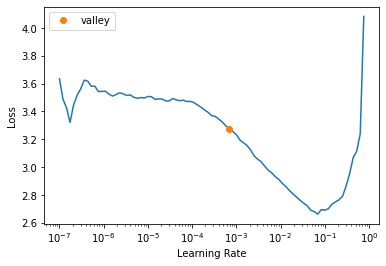

In [56]:
#Find the best learning rate for the model

lr_steep = learn.lr_find()
lr_steep = lr_steep[0]
print(f"steepest point: {lr_steep:.2e}")

In [57]:
callbacks = [SaveModelCallback(fname='fire_break_model'),CSVLogger(append=True)]